In [1]:
#pip install tensorflow

In [2]:
# Ejemplo univariado LSTM
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential # para construir modelos de redes neuronales de manera secuencial capa por capa.
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense #cada neurona está conectada a todas las neuronas de la capa anterior.
from tensorflow.keras.layers import Flatten # Su propósito es aplanar (flatten) los datos multidimensionales de entrada en una única dimensión.
from array import array

# Función que servirá para la transformación de datos:

In [3]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):

	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		# ej = 110,125,133 es "x" / end_ix= 146
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# 1. Recopilación y exploración de datos:

Importación de serie

In [4]:
local_btc = 'C:/Users/Josvaldes/Documents/Maestria/Austral/2ano/analisisST/TP1/SerieT/ST-main/ST-main/Datos históricos Bitcoin 2013.csv'
local_vix='C:/Users/Josvaldes/Documents/Maestria/Austral/2ano/analisisST/TP1/SerieT/ST-main/ST-main/Datos históricos CBOE Volatility Index.csv'
local_spy='C:/Users/Josvaldes/Documents/Maestria/Austral/2ano/analisisST/TP1/SerieT/ST-main/ST-main/Datos históricos SPY (1).csv'


In [5]:
btc_ts = pd.read_csv(local_btc,  parse_dates=['Fecha'], index_col='Fecha', dayfirst=True)
btc_ts.rename(columns={'Último': 'Precio_BTC'}, inplace=True)
columns_to_drop = ['Apertura','Máximo','Mínimo','Vol.','% var.']
btc_ts.drop(columns=columns_to_drop, inplace=True)
btc_ts.head()

,Precio_BTC
Fecha,
2023-10-24,"34.106,1"
2023-10-23,"33.041,8"
2023-10-22,"29.984,2"
2023-10-21,"29.912,9"
2023-10-20,"29.674,5"


In [6]:
vix_ts = pd.read_csv(local_vix,  parse_dates=['Fecha'], index_col='Fecha', dayfirst=True)
vix_ts.rename(columns={'Último': 'Precio_VIX'}, inplace=True)
columns_to_drop = ['Apertura','Máximo','Mínimo','Vol.','% var.']
vix_ts.drop(columns=columns_to_drop, inplace=True)
vix_ts.head()

,Precio_VIX
Fecha,
2023-10-24,"18,97"
2023-10-23,"20,37"
2023-10-20,"21,71"
2023-10-19,"21,40"
2023-10-18,"19,22"


In [7]:
spy_ts = pd.read_csv(local_spy,  parse_dates=['Fecha'], index_col='Fecha', dayfirst=True)
spy_ts.rename(columns={'Último': 'Precio_SPY'}, inplace=True)
columns_to_drop = ['Apertura','Máximo','Mínimo','Vol.','% var.']
spy_ts.drop(columns=columns_to_drop, inplace=True)
spy_ts.head()

,Precio_SPY
Fecha,
2023-10-24,"423,63"
2023-10-23,"420,46"
2023-10-20,"421,19"
2023-10-19,"426,43"
2023-10-18,"430,21"


Validación de nulos

In [8]:
btc_ts=btc_ts.dropna()
vix_ts=vix_ts.dropna()
spy_ts=spy_ts.dropna()

# Verificamos si hay nulos
print(btc_ts.isnull().values.any())
# Verificamos si hay nulos
print(vix_ts.isnull().values.any())
# Verificamos si hay nulos
print(spy_ts.isnull().values.any())

False
False
False


In [9]:
# Convierte la columna Precios en cadenas
btc_ts['Precio_BTC'] = btc_ts['Precio_BTC'].astype(str)
# Reemplaza los puntos por nada (eliminar los puntos) y luego reemplaza las comas por puntos decimales
btc_ts['Precio_BTC'] = btc_ts['Precio_BTC'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
btc_ts.head()

,Precio_BTC
Fecha,
2023-10-24,34106.1
2023-10-23,33041.8
2023-10-22,29984.2
2023-10-21,29912.9
2023-10-20,29674.5


In [10]:
# Convierte la columna Precios en cadenas
vix_ts['Precio_VIX'] = vix_ts['Precio_VIX'].astype(str)
spy_ts['Precio_SPY'] = spy_ts['Precio_SPY'].astype(str)

In [11]:
# Conversión de comas por punto de las series VIx y SPY
vix_ts['Precio_VIX'] = vix_ts['Precio_VIX'].str.replace(',', '.', regex=False).astype(float)
spy_ts['Precio_SPY'] = spy_ts['Precio_SPY'].str.replace(',', '.', regex=False).astype(float)

In [12]:
precios= btc_ts.merge(vix_ts,on='Fecha').merge(spy_ts,on='Fecha')
print(precios)

            Precio_BTC  Precio_VIX  Precio_SPY
Fecha                                         
2023-10-24     34106.1       18.97      423.63
2023-10-23     33041.8       20.37      420.46
2023-10-20     29674.5       21.71      421.19
2023-10-19     28723.0       21.40      426.43
2023-10-18     28321.7       19.22      430.21
...                ...         ...         ...
2013-02-07        22.1       13.50      150.96
2013-02-06        21.2       13.41      151.16
2013-02-05        20.6       13.72      151.05
2013-02-04        20.4       14.67      149.53
2013-02-01        20.5       12.90      151.24

[2701 rows x 3 columns]


In [13]:
precios.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2701 entries, 2023-10-24 to 2013-02-01
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Precio_BTC  2701 non-null   float64
 1   Precio_VIX  2701 non-null   float64
 2   Precio_SPY  2701 non-null   float64
dtypes: float64(3)
memory usage: 84.4 KB


In [14]:
precios = precios.asfreq(pd.infer_freq(precios.index))
precios.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3918 entries, 2013-02-01 to 2023-10-24
Freq: D
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Precio_BTC  2701 non-null   float64
 1   Precio_VIX  2701 non-null   float64
 2   Precio_SPY  2701 non-null   float64
dtypes: float64(3)
memory usage: 122.4 KB


In [15]:
# Verificamos si hay nulos
print(precios.isnull().values.any())

True


In [16]:
precios.dropna(inplace=True)
print(precios.isnull().values.any())

False


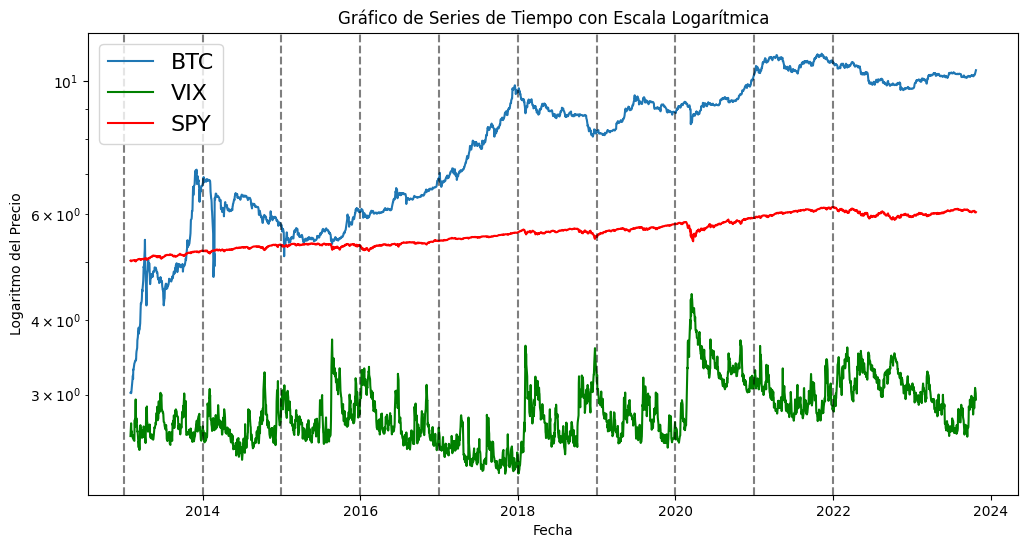

In [17]:
import matplotlib.pyplot as plt
from datetime import datetime

plt.figure(figsize=(12,6))

# Tomamos el logaritmo de las columnas de precio para aplicar escala logarítmica
btc_ts, = plt.plot(precios['Precio_BTC'].apply(np.log))
vix_ts, = plt.plot(precios['Precio_VIX'].apply(np.log), color='green')
spy_ts, = plt.plot(precios['Precio_SPY'].apply(np.log), color='red')

for year in range(2013, 2023):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['BTC', 'VIX', 'SPY'], fontsize=16)

plt.yscale('log')  # Aplicar escala logarítmica al eje y
plt.xlabel('Fecha')
plt.ylabel('Logaritmo del Precio')
plt.title('Gráfico de Series de Tiempo con Escala Logarítmica')

plt.show()

Se presenta las tres graficas de manera informativa dado que el objeto de las mismas hace que su interpretación sea diferente, se usa una transformación logarítmica para esta visualización.

In [18]:
precios

,Precio_BTC,Precio_VIX,Precio_SPY
Fecha,,,
2013-02-01,20.5,12.90,151.24
2013-02-04,20.4,14.67,149.53
2013-02-05,20.6,13.72,151.05
2013-02-06,21.2,13.41,151.16
2013-02-07,22.1,13.50,150.96
...,...,...,...
2023-10-18,28321.7,19.22,430.21
2023-10-19,28723.0,21.40,426.43
2023-10-20,29674.5,21.71,421.19


In [19]:
# define input sequence
timeseries_data = precios['Precio_BTC'].values
# choose a number of time steps
n_steps = 3
# split into samples
# preparo las variables dependientes e independientes.
X, y = prepare_data(timeseries_data, n_steps)

In [20]:
print(X)

[[2.05000e+01 2.04000e+01 2.06000e+01]
 [2.04000e+01 2.06000e+01 2.12000e+01]
 [2.06000e+01 2.12000e+01 2.21000e+01]
 ...
 [2.84036e+04 2.83217e+04 2.87230e+04]
 [2.83217e+04 2.87230e+04 2.96745e+04]
 [2.87230e+04 2.96745e+04 3.30418e+04]]


In [21]:
y

array([2.12000e+01, 2.21000e+01, 2.27000e+01, ..., 2.96745e+04,
       3.30418e+04, 3.41061e+04])

In [22]:
X.shape

(2698, 3)

Ahora debemos estructurar los datos en lotes (batches) y en tensores 3D con la forma (número de muestras, pasos de tiempo, características) necesaria para aplicar LSTM:

El propósito de esta línea de código es reorganizar las dimensiones de X para que sea compatible con la entrada esperada por una red LSTM. Las redes LSTM en Keras (o TensorFlow) esperan un tensor tridimensional con las siguientes dimensiones:

Dimensión 1: Número de muestras.
Dimensión 2: Longitud de cada secuencia (pasos de tiempo).
Dimensión 3: Número de características (features) en cada paso de tiempo.

In [23]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1  # para convertir X en una variable de 3 dimensiones.Este valor indica el número de características en la entrada,
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [24]:
X.shape

(2698, 3, 1)

In [25]:
X

array([[[2.05000e+01],
        [2.04000e+01],
        [2.06000e+01]],

       [[2.04000e+01],
        [2.06000e+01],
        [2.12000e+01]],

       [[2.06000e+01],
        [2.12000e+01],
        [2.21000e+01]],

       ...,

       [[2.84036e+04],
        [2.83217e+04],
        [2.87230e+04]],

       [[2.83217e+04],
        [2.87230e+04],
        [2.96745e+04]],

       [[2.87230e+04],
        [2.96745e+04],
        [3.30418e+04]]])

# 1.1. VIX

In [26]:
# define input sequence VIX
timeseries_data_VIX = precios['Precio_VIX'].values

X_VIX, y_VIX = prepare_data(timeseries_data_VIX, n_steps)

X_VIX = X_VIX.reshape((X.shape[0], X.shape[1], n_features))

# 1.2 SPY

In [27]:
# define input sequence SPY
timeseries_data_SPY = precios['Precio_SPY'].values

X_SPY, y_SPY = prepare_data(timeseries_data_SPY, n_steps)

X_SPY = X_SPY.reshape((X.shape[0], X.shape[1], n_features))

# 2. Construcción del modelo LSTM

In [28]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))     # return_sequences=True, input_shape=(n_steps, n_features)))
# model.add(LSTM(50, activation='relu')) - Rectified Linear Unit (o unidad lineal rectificada)
model.add(Dense(1))  # output node
model.compile(optimizer='Nadam', loss='mse') #Indica el algoritmo de descenso de gradiente que vamos a usar junto con la tasa de aprendizaje o learning_rate

# fit model
model.fit(X, y, epochs=50, verbose=1) # Epoch. Este es el numero de veces que se ejecutaran los algoritmos



Epoch 1/50

85/85 [==============================] - 3s 5ms/step - loss: 92613704.0000
Epoch 2/50
85/85 [==============================] - 0s 4ms/step - loss: 1184040.1250
Epoch 3/50
85/85 [==============================] - 0s 3ms/step - loss: 1425166.7500
Epoch 4/50
85/85 [==============================] - 0s 3ms/step - loss: 1234344.8750
Epoch 5/50
85/85 [==============================] - 0s 3ms/step - loss: 1264099.0000
Epoch 6/50
85/85 [==============================] - 0s 3ms/step - loss: 1286895.8750
Epoch 7/50
85/85 [==============================] - 0s 3ms/step - loss: 1225538.3750
Epoch 8/50
85/85 [==============================] - 0s 3ms/step - loss: 1247064.3750
Epoch 9/50
85/85 [==============================] - 0s 3ms/step - loss: 1236763.7500
Epoch 10/50
85/85 [==============================] - 0s 3ms/step - loss: 1203191.0000
Epoch 11/50
85/85 [==============================] - 0s 3ms/step - loss: 1180440.6250
Epoch 12/50
85/85 [==============================] - 0s 3ms

# 2.1 VIX

In [29]:
model_VIX = Sequential()
model_VIX.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))     # return_sequences=True, input_shape=(n_steps, n_features)))
#model_VIX.add(LSTM(50, activation='relu')) #- Rectified Linear Unit (o unidad lineal rectificada); se agrega segunda capa LSTM
model_VIX.add(Dense(1))  # output node
model_VIX.compile(optimizer='Nadam', loss='mse') #Indica el algoritmo de descenso de gradiente que vamos a usar junto con la tasa de aprendizaje o learning_rate

# fit model
model_VIX.fit(X_VIX, y_VIX, epochs=50, verbose=1) # Epoch. Este es el numero de veces que se ejecutaran los algoritmos

Epoch 1/50
85/85 [==============================] - 2s 3ms/step - loss: 89.1779
Epoch 2/50
85/85 [==============================] - 0s 3ms/step - loss: 5.2994
Epoch 3/50
85/85 [==============================] - 0s 3ms/step - loss: 4.7222
Epoch 4/50
85/85 [==============================] - 0s 3ms/step - loss: 4.3783
Epoch 5/50
85/85 [==============================] - 0s 3ms/step - loss: 4.1014
Epoch 6/50
85/85 [==============================] - 0s 3ms/step - loss: 3.9546
Epoch 7/50
85/85 [==============================] - 0s 3ms/step - loss: 3.5742
Epoch 8/50
85/85 [==============================] - 0s 3ms/step - loss: 3.5249
Epoch 9/50
85/85 [==============================] - 0s 3ms/step - loss: 3.3860
Epoch 10/50
85/85 [==============================] - 0s 3ms/step - loss: 3.3821
Epoch 11/50
85/85 [==============================] - 0s 3ms/step - loss: 3.2840
Epoch 12/50
85/85 [==============================] - 0s 3ms/step - loss: 3.2940
Epoch 13/50
85/85 [=============================

# 2.2 SPY

In [30]:
model_SPY = Sequential()
model_SPY.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))     # return_sequences=True, input_shape=(n_steps, n_features)))
# model.add(LSTM(50, activation='relu')) - Rectified Linear Unit (o unidad lineal rectificada)
model_SPY.add(Dense(1))  # output node
model_SPY.compile(optimizer='Nadam', loss='mse') #Indica el algoritmo de descenso de gradiente que vamos a usar junto con la tasa de aprendizaje o learning_rate

# fit model
model_SPY.fit(X_SPY, y_SPY, epochs=50, verbose=1) # Epoch. Este es el numero de veces que se ejecutaran los algoritmos

Epoch 1/50
85/85 [==============================] - 2s 4ms/step - loss: 50012.4766
Epoch 2/50
85/85 [==============================] - 0s 3ms/step - loss: 18.1902
Epoch 3/50
85/85 [==============================] - 0s 3ms/step - loss: 18.2224
Epoch 4/50
85/85 [==============================] - 0s 4ms/step - loss: 18.0683
Epoch 5/50
85/85 [==============================] - 0s 3ms/step - loss: 18.1216
Epoch 6/50
85/85 [==============================] - 0s 3ms/step - loss: 17.8336
Epoch 7/50
85/85 [==============================] - 0s 3ms/step - loss: 17.9618
Epoch 8/50
85/85 [==============================] - 0s 3ms/step - loss: 17.8802
Epoch 9/50
85/85 [==============================] - 0s 3ms/step - loss: 17.8936
Epoch 10/50
85/85 [==============================] - 0s 3ms/step - loss: 18.0762
Epoch 11/50
85/85 [==============================] - 0s 3ms/step - loss: 17.9788
Epoch 12/50
85/85 [==============================] - 0s 3ms/step - loss: 17.7576
Epoch 13/50
85/85 [===============

# 3. Predicción: horizonte temporal de 10 días:

In [31]:
y

array([2.12000e+01, 2.21000e+01, 2.27000e+01, ..., 2.96745e+04,
       3.30418e+04, 3.41061e+04])

In [32]:
y[-3:]

array([29674.5, 33041.8, 34106.1])

In [33]:
# Output para un horizonte temporal de 10 dias

import numpy as np

x_input = y[-3:]
temp_input=list(x_input)
lst_output=[]
i=0
while(i<10):

    if(len(temp_input)>3):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1


print(lst_output)

[33776.785]
1 day input [33041.8        34106.1        33776.78515625]
1 day output [[34520.086]]
2 day input [34106.1        33776.78515625 34520.0859375 ]
2 day output [[35043.45]]
3 day input [33776.785 34520.086 35043.45 ]
3 day output [[35480.008]]
4 day input [34520.086 35043.45  35480.008]
4 day output [[36008.39]]
5 day input [35043.45  35480.008 36008.39 ]
5 day output [[36522.69]]
6 day input [35480.008 36008.39  36522.69 ]
6 day output [[37038.305]]
7 day input [36008.39  36522.69  37038.305]
7 day output [[37567.977]]
8 day input [36522.69  37038.305 37567.977]
8 day output [[38103.223]]
9 day input [37038.305 37567.977 38103.223]
9 day output [[38645.727]]
[33776.785, 34520.086, 35043.45, 35480.008, 36008.39, 36522.69, 37038.305, 37567.977, 38103.223, 38645.727]


In [34]:
timeseries_data

array([2.05000e+01, 2.04000e+01, 2.06000e+01, ..., 2.96745e+04,
       3.30418e+04, 3.41061e+04])

In [35]:
len(timeseries_data)

2701

## 3.1 VIX

In [36]:
# Output para un horizonte temporal de 10 dias

import numpy as np

x_input_VIX = y_VIX[-3:]
temp_input_VIX=list(x_input_VIX)
lst_output_VIX=[]
i=0
while(i<10):

    if(len(temp_input_VIX)>3):
        x_input_VIX=np.array(temp_input_VIX[1:])
        print("{} day input {}".format(i,x_input_VIX))
        #print(x_input)
        x_input_VIX = x_input_VIX.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat_VIX = model_VIX.predict(x_input_VIX, verbose=0)
        print("{} day output {}".format(i,yhat_VIX))
        temp_input_VIX.append(yhat_VIX[0][0])
        temp_input_VIX=temp_input_VIX[1:]
        #print(temp_input)
        lst_output_VIX.append(yhat_VIX[0][0])
        i=i+1
    else:
        x_input_VIX = x_input_VIX.reshape((1, n_steps, n_features))
        yhat_VIX = model_VIX.predict(x_input_VIX, verbose=0)
        print(yhat_VIX[0])
        temp_input_VIX.append(yhat_VIX[0][0])
        lst_output_VIX.append(yhat_VIX[0][0])
        i=i+1


print(lst_output_VIX)

[18.742548]
1 day input [20.37       18.97       18.74254799]
1 day output [[18.512852]]
2 day input [18.97       18.74254799 18.51285172]
2 day output [[18.282234]]
3 day input [18.742548 18.512852 18.282234]
3 day output [[18.067345]]
4 day input [18.512852 18.282234 18.067345]
4 day output [[17.86649]]
5 day input [18.282234 18.067345 17.86649 ]
5 day output [[17.678392]]
6 day input [18.067345 17.86649  17.678392]
6 day output [[17.502203]]
7 day input [17.86649  17.678392 17.502203]
7 day output [[17.33711]]
8 day input [17.678392 17.502203 17.33711 ]
8 day output [[17.182346]]
9 day input [17.502203 17.33711  17.182346]
9 day output [[17.037195]]
[18.742548, 18.512852, 18.282234, 18.067345, 17.86649, 17.678392, 17.502203, 17.33711, 17.182346, 17.037195]


## 3.2 SPY

In [37]:
# Output para un horizonte temporal de 10 dias

x_input_SPY = y_SPY[-3:]
temp_input_SPY=list(x_input_SPY)
lst_output_SPY=[]
i=0
while(i<10):

    if(len(temp_input_SPY)>3):
        x_input_SPY=np.array(temp_input_SPY[1:])
        print("{} day input {}".format(i,x_input_SPY))
        #print(x_input)
        x_input_SPY = x_input_SPY.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat_SPY = model_VIX.predict(x_input_SPY, verbose=0)
        print("{} day output {}".format(i,yhat_SPY))
        temp_input_SPY.append(yhat_SPY[0][0])
        temp_input_SPY=temp_input_SPY[1:]
        #print(temp_input)
        lst_output_SPY.append(yhat_SPY[0][0])
        i=i+1
    else:
        x_input_SPY = x_input_SPY.reshape((1, n_steps, n_features))
        yhat_SPY= model_SPY.predict(x_input_SPY, verbose=0)
        print(yhat_SPY[0])
        temp_input_SPY.append(yhat_SPY[0][0])
        lst_output_SPY.append(yhat_SPY[0][0])
        i=i+1


print(lst_output_SPY)

[420.18716]
1 day input [420.46       423.63       420.18716431]
1 day output [[389.84192]]
2 day input [423.63       420.18716431 389.84191895]
2 day output [[334.3508]]
3 day input [420.18716 389.84192 334.3508 ]
3 day output [[296.1254]]
4 day input [389.84192 334.3508  296.1254 ]
4 day output [[263.0596]]
5 day input [334.3508 296.1254 263.0596]
5 day output [[232.10374]]
6 day input [296.1254  263.0596  232.10374]
6 day output [[205.28177]]
7 day input [263.0596  232.10374 205.28177]
7 day output [[181.73317]]
8 day input [232.10374 205.28177 181.73317]
8 day output [[160.89206]]
9 day input [205.28177 181.73317 160.89206]
9 day output [[142.57559]]
[420.18716, 389.84192, 334.3508, 296.1254, 263.0596, 232.10374, 205.28177, 181.73317, 160.89206, 142.57559]


# 4. Vizualizamos el output

Text(0.5, 1.0, 'Prediccion de precios de Bitcoin')

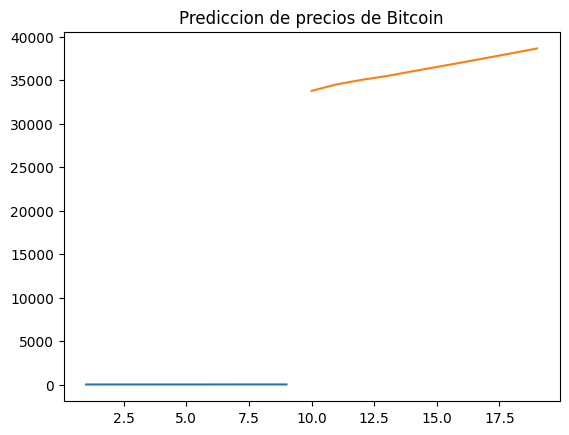

In [38]:
import matplotlib.pyplot as plt
day_new=np.arange(1,10)
day_pred=np.arange(10,20)

plt.plot(day_new,timeseries_data[:9])
plt.plot(day_pred,lst_output)
plt.title('Prediccion de precios de Bitcoin')

## 4.1 VIX

Text(0.5, 1.0, 'Prediccion de precios de VIX')

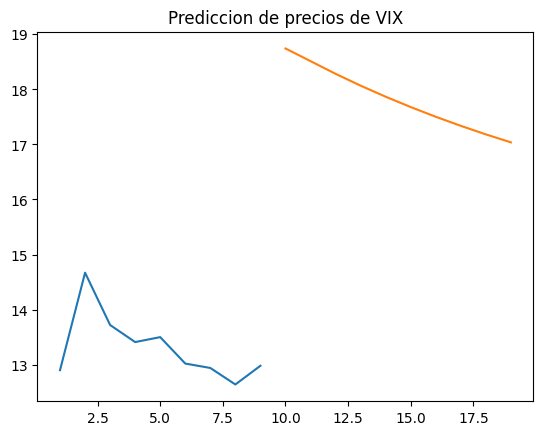

In [91]:
plt.plot(day_new,timeseries_data_VIX[:9])
plt.plot(day_pred,lst_output_VIX)
plt.title('Prediccion de precios de VIX')

## 4.2 SPY

Text(0.5, 1.0, 'Prediccion de precios de SPY')

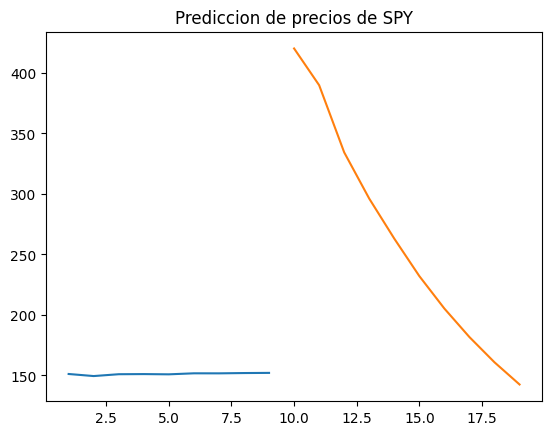

In [40]:
plt.plot(day_new,timeseries_data_SPY[:9])
plt.plot(day_pred,lst_output_SPY)
plt.title('Prediccion de precios de SPY')

In [41]:
df_time_diffs = precios.index.to_series().diff().dt.total_seconds() #total_seconds es una función de pandas que retorna la duración total de cada elemento expresada en segundos.
print(df_time_diffs.value_counts())

Fecha
86400.0     2116
259200.0     487
345600.0      73
172800.0      24
Name: count, dtype: int64


Todos los datos estan con una diferencia de 24 horas.

In [42]:
precios

,Precio_BTC,Precio_VIX,Precio_SPY
Fecha,,,
2013-02-01,20.5,12.90,151.24
2013-02-04,20.4,14.67,149.53
2013-02-05,20.6,13.72,151.05
2013-02-06,21.2,13.41,151.16
2013-02-07,22.1,13.50,150.96
...,...,...,...
2023-10-18,28321.7,19.22,430.21
2023-10-19,28723.0,21.40,426.43
2023-10-20,29674.5,21.71,421.19


In [43]:
precios.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2701 entries, 2013-02-01 to 2023-10-24
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Precio_BTC  2701 non-null   float64
 1   Precio_VIX  2701 non-null   float64
 2   Precio_SPY  2701 non-null   float64
dtypes: float64(3)
memory usage: 84.4 KB


In [44]:
precios.shape


(2701, 3)

# 5. Modelo univariado-unistep

In [45]:
#Función para división de la serie
def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

In [46]:
tr, vl, ts = train_val_test_split(precios['Precio_BTC'])

# Imprimir en pantalla el tamaño de cada subset
print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (2160,)
Tamaño set de validación: (270,)
Tamaño set de prueba: (271,)


Text(0.5, 1.0, 'División de la serie BTC')

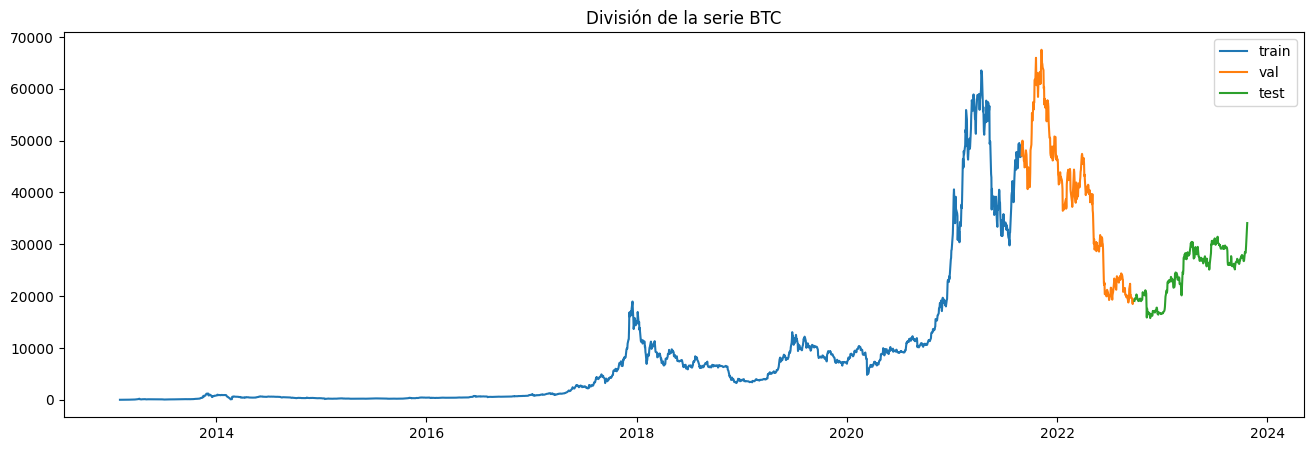

In [47]:
# Grafica de la división de la serie
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(tr,label="train")
ax.plot(vl,label="val")
ax.plot(ts,label="test")
plt.legend()
plt.title('División de la serie BTC')

VIX

In [48]:
tr_VIX, vl_VIX, ts_VIX = train_val_test_split(precios['Precio_VIX'])

# Imprimir en pantalla el tamaño de cada subset
print(f'Tamaño set de entrenamiento: {tr_VIX.shape}')
print(f'Tamaño set de validación: {vl_VIX.shape}')
print(f'Tamaño set de prueba: {ts_VIX.shape}')

Tamaño set de entrenamiento: (2160,)
Tamaño set de validación: (270,)
Tamaño set de prueba: (271,)


Text(0.5, 1.0, 'División de la serie VIX')

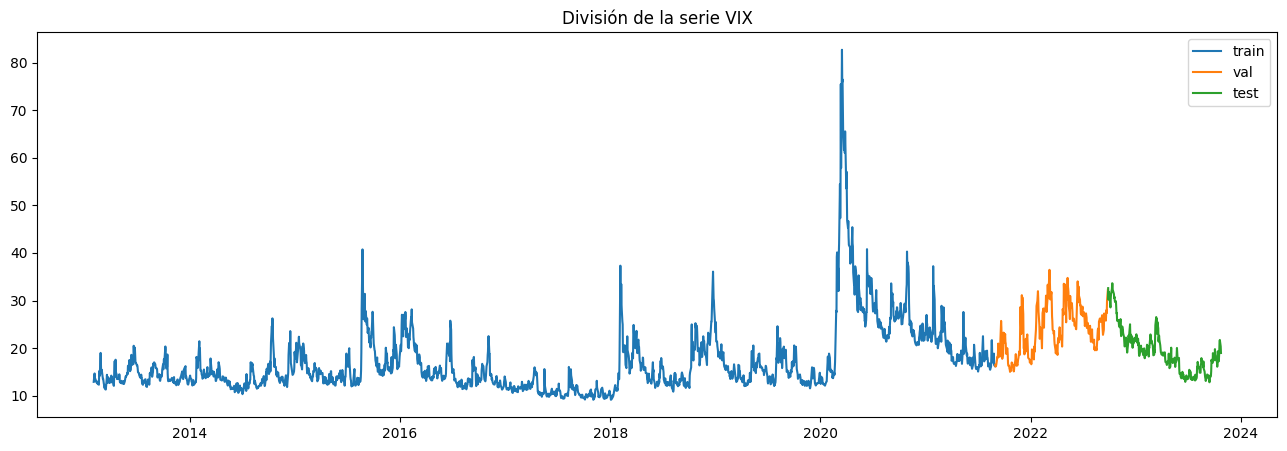

In [49]:
# Grafica de la división de la serie
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(tr_VIX,label="train")
ax.plot(vl_VIX,label="val")
ax.plot(ts_VIX,label="test")
plt.legend()
plt.title('División de la serie VIX')

SPY

In [50]:
tr_SPY, vl_SPY, ts_SPY = train_val_test_split(precios['Precio_SPY'])

# Imprimir en pantalla el tamaño de cada subset
print(f'Tamaño set de entrenamiento: {tr_SPY.shape}')
print(f'Tamaño set de validación: {vl_SPY.shape}')
print(f'Tamaño set de prueba: {ts_SPY.shape}')

Tamaño set de entrenamiento: (2160,)
Tamaño set de validación: (270,)
Tamaño set de prueba: (271,)


Text(0.5, 1.0, 'División de la serie SPY')

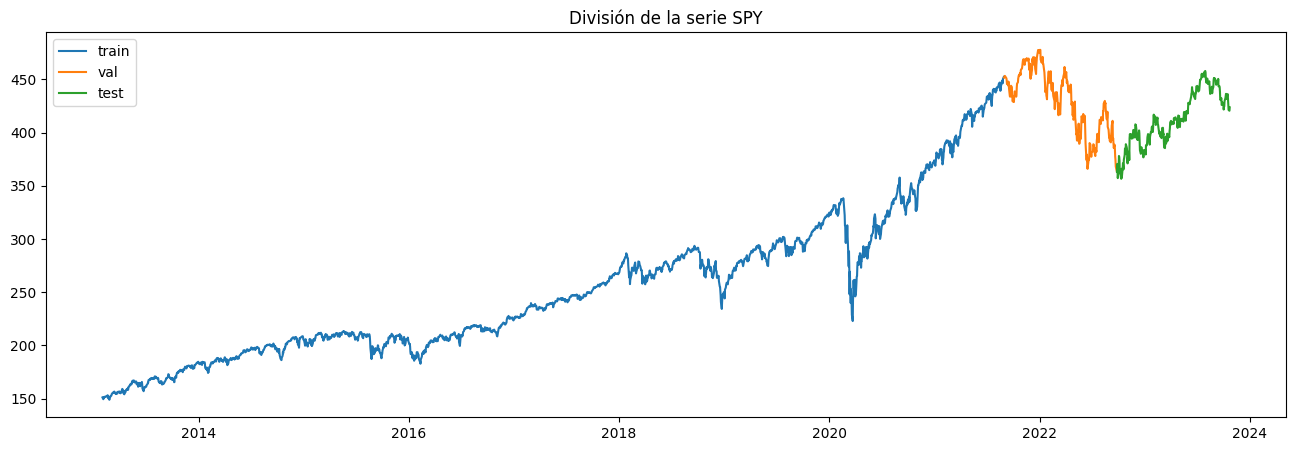

In [51]:
# Grafica de la división de la serie
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(tr_SPY,label="train")
ax.plot(vl_SPY,label="val")
ax.plot(ts_SPY,label="test")
plt.legend()
plt.title('División de la serie SPY')

# 5.1. Adecuación para una red LSTM: Dataset supervisado

In [52]:
# Función para el pre procesamiento de los datos en las divisiones realizadas
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos (utilizando ventanas deslizantes de longitud input_length)
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [53]:
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 24    # Registros de 240 min consecutivos a la entrada
OUTPUT_LENGTH = 1    # El modelo va a predecir 10 min a futuro

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

In [54]:
# Visualización
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (2135, 24, 1), y_tr: (2135, 1, 1)
Set de validación - x_vl: (245, 24, 1), y_vl: (245, 1, 1)
Set de prueba - x_ts: (246, 24, 1), y_ts: (246, 1, 1)


VIX

In [55]:
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 24    # Registros de 240 min consecutivos a la entrada
OUTPUT_LENGTH = 1    # El modelo va a predecir 10 min a futuro

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr_VIX, y_tr_VIX = crear_dataset_supervisado(tr_VIX.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl_VIX, y_vl_VIX = crear_dataset_supervisado(vl_VIX.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts_VIX, y_ts_VIX = crear_dataset_supervisado(ts_VIX.values, INPUT_LENGTH, OUTPUT_LENGTH)

In [56]:
# Visualización
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr_VIX.shape}, y_tr: {y_tr_VIX.shape}')
print(f'Set de validación - x_vl: {x_vl_VIX.shape}, y_vl: {y_vl_VIX.shape}')
print(f'Set de prueba - x_ts: {x_ts_VIX.shape}, y_ts: {y_ts_VIX.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (2135, 24, 1), y_tr: (2135, 1, 1)
Set de validación - x_vl: (245, 24, 1), y_vl: (245, 1, 1)
Set de prueba - x_ts: (246, 24, 1), y_ts: (246, 1, 1)


SPY

In [57]:
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 24    # Registros de 240 min consecutivos a la entrada
OUTPUT_LENGTH = 1    # El modelo va a predecir 10 min a futuro

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr_SPY, y_tr_SPY = crear_dataset_supervisado(tr_SPY.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl_SPY, y_vl_SPY = crear_dataset_supervisado(vl_SPY.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts_SPY, y_ts_SPY = crear_dataset_supervisado(ts_SPY.values, INPUT_LENGTH, OUTPUT_LENGTH)

In [58]:
# Visualización
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr_SPY.shape}, y_tr: {y_tr_SPY.shape}')
print(f'Set de validación - x_vl: {x_vl_SPY.shape}, y_vl: {y_vl_SPY.shape}')
print(f'Set de prueba - x_ts: {x_ts_SPY.shape}, y_ts: {y_ts_SPY.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (2135, 24, 1), y_tr: (2135, 1, 1)
Set de validación - x_vl: (245, 24, 1), y_vl: (245, 1, 1)
Set de prueba - x_ts: (246, 24, 1), y_ts: (246, 1, 1)


# 5.2. Escalamiento de los datos

In [59]:
# Función de escalamiento de datos
from sklearn.preprocessing import MinMaxScaler


def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados (Se crean arreglos vacíos con las mismas dimensiones que los conjuntos de datos originales para almacenar los datos escalados)
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs (aca es una sola feature, pero en un multivariado ya nos quedará a estructura)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i]) #ajustamos a los datos de entrenamiento
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i]) #transformamos con el ajuste a val y a test tomando el rango del set de entrenamiento
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys (Se asume que las etiquetas se encuentran en la última columna de los conjuntos de datos...ademas, en este caso es una sola columna)
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0] #útil para realizar la inversión de escalamiento

In [60]:
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

In [61]:
data_s, scaler = escalar_dataset(data_in)

In [62]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [63]:
# Validación de los datos escalados
print(f'Min x_tr/x_vl/x_ts sin escalamiento:  {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento:  {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'Min y_tr/y_vl/y_ts sin escalamiento:  {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento:  {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'Max x_tr/x_vl/x_ts sin escalamiento:  {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento:  {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'Max y_tr/y_vl/y_ts sin escalamiento:  {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento:  {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')


Min x_tr/x_vl/x_ts sin escalamiento:  20.4/18489.0/15776.2
Min x_tr/x_vl/x_ts con escalamiento:  -1.0/-0.4189820611065703/-0.50442606092389
Min y_tr/y_vl/y_ts sin escalamiento:  44.2/18489.0/15776.2
Min y_tr/y_vl/y_ts con escalamiento:  -1.0/-0.41903122524477665/-0.5044781854805054
Max x_tr/x_vl/x_ts sin escalamiento:  63540.9/67527.9/31466.1
Max x_tr/x_vl/x_ts con escalamiento:  1.0000000000000004/1.12557697849884/-0.009903889295581725
Max y_tr/y_vl/y_ts sin escalamiento:  63540.9/67527.9/33041.8
Max y_tr/y_vl/y_ts con escalamiento:  0.9999999999999996/1.1255813294234183/0.03934850157567227


VIX

In [64]:
data_in_VIX = {
    'x_tr': x_tr_VIX, 'y_tr': y_tr_VIX,
    'x_vl': x_vl_VIX, 'y_vl': y_vl_VIX,
    'x_ts': x_ts_VIX, 'y_ts': y_ts_VIX,
}

data_s_VIX, scaler_VIX = escalar_dataset(data_in_VIX)

x_tr_s_VIX, y_tr_s_VIX = data_s_VIX['x_tr_s'], data_s_VIX['y_tr_s']
x_vl_s_VIX, y_vl_s_VIX = data_s_VIX['x_vl_s'], data_s_VIX['y_vl_s']
x_ts_s_VIX, y_ts_s_VIX = data_s_VIX['x_ts_s'], data_s_VIX['y_ts_s']


# Validación de los datos escalados
print(f'Min x_tr/x_vl/x_ts sin escalamiento:  {x_tr_VIX.min()}/{x_vl_VIX.min()}/{x_ts_VIX.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento:  {x_tr_s_VIX.min()}/{x_vl_s_VIX.min()}/{x_ts_s_VIX.min()}')

print(f'Min y_tr/y_vl/y_ts sin escalamiento:  {y_tr_VIX.min()}/{y_vl_VIX.min()}/{y_ts_VIX.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento:  {y_tr_s_VIX.min()}/{y_vl_s_VIX.min()}/{y_ts_s_VIX.min()}')

print(f'Max x_tr/x_vl/x_ts sin escalamiento:  {x_tr_VIX.max()}/{x_vl_VIX.max()}/{x_ts_VIX.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento:  {x_tr_s_VIX.max()}/{x_vl_s_VIX.max()}/{x_ts_s_VIX.max()}')

print(f'Max y_tr/y_vl/y_ts sin escalamiento:  {y_tr_VIX.max()}/{y_vl_VIX.max()}/{y_ts_VIX.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento:  {y_tr_s_VIX.max()}/{y_vl_s_VIX.max()}/{y_ts_s_VIX.max()}')


Min x_tr/x_vl/x_ts sin escalamiento:  9.14/15.01/12.82
Min x_tr/x_vl/x_ts con escalamiento:  -1.0/-0.4189820611065703/-0.50442606092389
Min y_tr/y_vl/y_ts sin escalamiento:  9.14/15.01/12.82
Min y_tr/y_vl/y_ts con escalamiento:  -1.0/-0.41903122524477665/-0.5044781854805054
Max x_tr/x_vl/x_ts sin escalamiento:  82.69/36.45/33.63
Max x_tr/x_vl/x_ts con escalamiento:  1.0000000000000004/1.12557697849884/-0.009903889295581725
Max y_tr/y_vl/y_ts sin escalamiento:  82.69/36.45/26.52
Max y_tr/y_vl/y_ts con escalamiento:  0.9999999999999996/1.1255813294234183/0.03934850157567227


SPY

In [65]:
data_in_SPY = {
    'x_tr': x_tr_SPY, 'y_tr': y_tr_SPY,
    'x_vl': x_vl_SPY, 'y_vl': y_vl_SPY,
    'x_ts': x_ts_SPY, 'y_ts': y_ts_SPY,
}

data_s_SPY, scaler_SPY = escalar_dataset(data_in_SPY)

x_tr_s_SPY, y_tr_s_SPY = data_s_SPY['x_tr_s'], data_s_SPY['y_tr_s']
x_vl_s_SPY, y_vl_s_SPY = data_s_SPY['x_vl_s'], data_s_SPY['y_vl_s']
x_ts_s_SPY, y_ts_s_SPY = data_s_SPY['x_ts_s'], data_s_SPY['y_ts_s']


# Validación de los datos escalados
print(f'Min x_tr/x_vl/x_ts sin escalamiento:  {x_tr_SPY.min()}/{x_vl_SPY.min()}/{x_ts_SPY.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento:  {x_tr_s_SPY.min()}/{x_vl_s_SPY.min()}/{x_ts_s_SPY.min()}')

print(f'Min y_tr/y_vl/y_ts sin escalamiento:  {y_tr_SPY.min()}/{y_vl_SPY.min()}/{y_ts_SPY.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento:  {y_tr_s_SPY.min()}/{y_vl_s_SPY.min()}/{y_ts_s_SPY.min()}')

print(f'Max x_tr/x_vl/x_ts sin escalamiento:  {x_tr_SPY.max()}/{x_vl_SPY.max()}/{x_ts_SPY.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento:  {x_tr_s_SPY.max()}/{x_vl_s_SPY.max()}/{x_ts_s_SPY.max()}')

print(f'Max y_tr/y_vl/y_ts sin escalamiento:  {y_tr_SPY.max()}/{y_vl_SPY.max()}/{y_ts_SPY.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento:  {y_tr_s_SPY.max()}/{y_vl_s_SPY.max()}/{y_ts_s_SPY.max()}')

Min x_tr/x_vl/x_ts sin escalamiento:  149.0/365.86/356.56
Min x_tr/x_vl/x_ts con escalamiento:  -1.0/-0.4189820611065703/-0.50442606092389
Min y_tr/y_vl/y_ts sin escalamiento:  154.14/365.86/371.01
Min y_tr/y_vl/y_ts con escalamiento:  -1.0/-0.41903122524477665/-0.5044781854805054
Max x_tr/x_vl/x_ts sin escalamiento:  448.91/477.71/457.79
Max x_tr/x_vl/x_ts con escalamiento:  1.0000000000000004/1.12557697849884/-0.009903889295581725
Max y_tr/y_vl/y_ts sin escalamiento:  450.25/477.71/457.79
Max y_tr/y_vl/y_ts con escalamiento:  0.9999999999999996/1.1255813294234183/0.03934850157567227


# 5.3. Creación y entrenamiento de la Red LSTM

In [66]:
import tensorflow as tf

tf.random.set_seed(123) #para garantizar la reproducibidad del entrenamiento

N_UNITS = 128 #número de unidades del modelo (que corresponde al tamaño del estado oculto y a la celda de memoria de la Red LSTM.
#hiperparámetro del modelo a afinar

INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) #cada uno de los datos de entrada será un arreglo de tamaño 24 (xxx minutos de entrada) x 1 (feature).

modelo2 = Sequential() #caja vacía a la cual se le adicionaran de manera secuencial los elementos
modelo2.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo2.add(Dense(OUTPUT_LENGTH, activation='linear'))

VIX

In [67]:
tf.random.set_seed(1234) #para garantizar la reproducibidad del entrenamiento

N_UNITS = 128 #número de unidades del modelo (que corresponde al tamaño del estado oculto y a la celda de memoria de la Red LSTM.
#hiperparámetro del modelo a afinar

INPUT_SHAPE_VIX = (x_tr_s_VIX.shape[1], x_tr_s_VIX.shape[2]) #cada uno de los datos de entrada será un arreglo de tamaño 24 (xxx minutos de entrada) x 1 (feature).

modelo_VIX = Sequential() #caja vacía a la cual se le adicionaran de manera secuencial los elementos
modelo_VIX.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE_VIX))
modelo_VIX.add(Dense(OUTPUT_LENGTH, activation='linear'))

SPY

In [68]:
tf.random.set_seed(1234) #para garantizar la reproducibidad del entrenamiento

N_UNITS = 128 #número de unidades del modelo (que corresponde al tamaño del estado oculto y a la celda de memoria de la Red LSTM.
#hiperparámetro del modelo a afinar

INPUT_SHAPE_SPY = (x_tr_s_SPY.shape[1], x_tr_s_SPY.shape[2]) #cada uno de los datos de entrada será un arreglo de tamaño 24 (xxx minutos de entrada) x 1 (feature).

modelo_SPY = Sequential() #caja vacía a la cual se le adicionaran de manera secuencial los elementos
modelo_SPY.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE_SPY))
modelo_SPY.add(Dense(OUTPUT_LENGTH, activation='linear'))

# 5.4. Compilación del modelo

In [69]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

In [70]:
from tensorflow.keras.optimizers import RMSprop

optimizador = RMSprop(learning_rate=5e-5)

In [71]:
modelo2.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

VIX

In [72]:
optimizador_VIX = RMSprop(learning_rate=5e-5)
modelo_VIX.compile(
    optimizer = optimizador_VIX,
    loss = root_mean_squared_error,
)

SPY

In [73]:
optimizador_SPY = RMSprop(learning_rate=5e-5)
modelo_SPY.compile(
    optimizer = optimizador_SPY,
    loss = root_mean_squared_error,
)

# 5.5. Entrenamiento del modelo

In [74]:
EPOCHS = 80 #iteraciones de entrenamiento
BATCH_SIZE = 256 #tamaño del lote (es decir, 256 datos de entrenamiento en cada iteración)

In [75]:
historia = modelo2.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2 #vemos como evoluciona el entrenamiento
)

Epoch 1/80
9/9 - 4s - loss: 0.7863 - val_loss: 0.4167 - 4s/epoch - 446ms/step
Epoch 2/80
9/9 - 1s - loss: 0.7156 - val_loss: 0.3943 - 605ms/epoch - 67ms/step
Epoch 3/80
9/9 - 1s - loss: 0.6549 - val_loss: 0.3728 - 614ms/epoch - 68ms/step
Epoch 4/80
9/9 - 1s - loss: 0.5926 - val_loss: 0.3510 - 621ms/epoch - 69ms/step
Epoch 5/80
9/9 - 1s - loss: 0.5259 - val_loss: 0.3282 - 644ms/epoch - 72ms/step
Epoch 6/80
9/9 - 1s - loss: 0.4519 - val_loss: 0.3045 - 589ms/epoch - 65ms/step
Epoch 7/80
9/9 - 1s - loss: 0.3683 - val_loss: 0.2800 - 588ms/epoch - 65ms/step
Epoch 8/80
9/9 - 1s - loss: 0.2727 - val_loss: 0.2556 - 595ms/epoch - 66ms/step
Epoch 9/80
9/9 - 1s - loss: 0.1681 - val_loss: 0.2332 - 633ms/epoch - 70ms/step
Epoch 10/80
9/9 - 1s - loss: 0.0967 - val_loss: 0.2206 - 572ms/epoch - 64ms/step
Epoch 11/80
9/9 - 1s - loss: 0.0876 - val_loss: 0.2116 - 623ms/epoch - 69ms/step
Epoch 12/80
9/9 - 1s - loss: 0.0841 - val_loss: 0.2024 - 571ms/epoch - 63ms/step
Epoch 13/80
9/9 - 1s - loss: 0.0807 - v

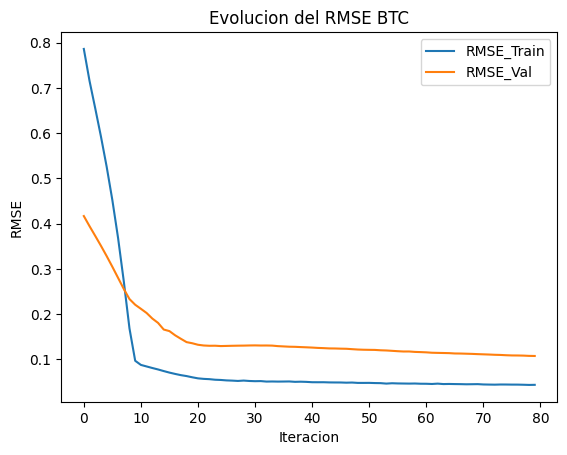

In [76]:
plt.plot(historia.history['loss'],label='RMSE_Train')
plt.plot(historia.history['val_loss'],label='RMSE_Val')
plt.xlabel('Iteracion')
plt.ylabel('RMSE')
plt.title('Evolucion del RMSE BTC')
plt.legend()

VIX

Epoch 1/80
9/9 - 4s - loss: 0.8274 - val_loss: 0.4453 - 4s/epoch - 422ms/step
Epoch 2/80
9/9 - 1s - loss: 0.7427 - val_loss: 0.4191 - 577ms/epoch - 64ms/step
Epoch 3/80
9/9 - 1s - loss: 0.6698 - val_loss: 0.3941 - 603ms/epoch - 67ms/step
Epoch 4/80
9/9 - 1s - loss: 0.5943 - val_loss: 0.3690 - 537ms/epoch - 60ms/step
Epoch 5/80
9/9 - 1s - loss: 0.5126 - val_loss: 0.3431 - 565ms/epoch - 63ms/step
Epoch 6/80
9/9 - 1s - loss: 0.4214 - val_loss: 0.3166 - 527ms/epoch - 59ms/step
Epoch 7/80
9/9 - 1s - loss: 0.3188 - val_loss: 0.2900 - 678ms/epoch - 75ms/step
Epoch 8/80
9/9 - 1s - loss: 0.2054 - val_loss: 0.2647 - 807ms/epoch - 90ms/step
Epoch 9/80
9/9 - 1s - loss: 0.1128 - val_loss: 0.2473 - 777ms/epoch - 86ms/step
Epoch 10/80
9/9 - 1s - loss: 0.0931 - val_loss: 0.2394 - 772ms/epoch - 86ms/step
Epoch 11/80
9/9 - 1s - loss: 0.0904 - val_loss: 0.2298 - 677ms/epoch - 75ms/step
Epoch 12/80
9/9 - 1s - loss: 0.0867 - val_loss: 0.2198 - 763ms/epoch - 85ms/step
Epoch 13/80
9/9 - 1s - loss: 0.0833 - v

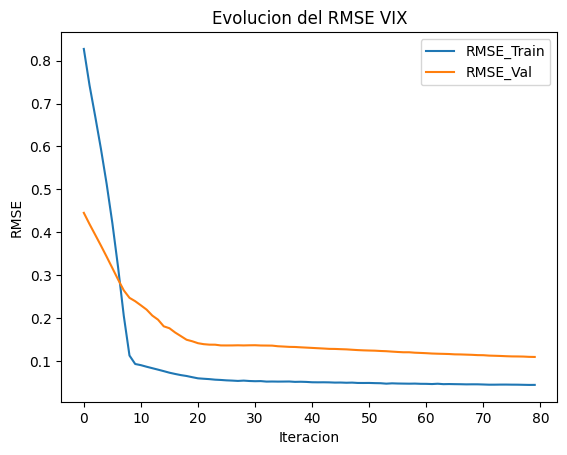

In [77]:
EPOCHS_VIX = 80 #iteraciones de entrenamiento
BATCH_SIZE_VIX = 256 #tamaño del lote (es decir, 256 datos de entrenamiento en cada iteración)

historia_VIX = modelo_VIX.fit(
    x = x_tr_s_VIX,
    y = y_tr_s_VIX,
    batch_size = BATCH_SIZE_VIX,
    epochs = EPOCHS_VIX,
    validation_data = (x_vl_s_VIX, y_vl_s_VIX),
    verbose=2 #vemos como evoluciona el entrenamiento
)

plt.plot(historia_VIX.history['loss'],label='RMSE_Train')
plt.plot(historia_VIX.history['val_loss'],label='RMSE_Val')
plt.xlabel('Iteracion')
plt.ylabel('RMSE')
plt.title('Evolucion del RMSE VIX')
plt.legend()

SPY

Epoch 1/80
9/9 - 4s - loss: 0.8650 - val_loss: 0.4599 - 4s/epoch - 412ms/step
Epoch 2/80
9/9 - 1s - loss: 0.7982 - val_loss: 0.4385 - 569ms/epoch - 63ms/step
Epoch 3/80
9/9 - 1s - loss: 0.7413 - val_loss: 0.4179 - 542ms/epoch - 60ms/step
Epoch 4/80
9/9 - 1s - loss: 0.6833 - val_loss: 0.3971 - 566ms/epoch - 63ms/step
Epoch 5/80
9/9 - 1s - loss: 0.6215 - val_loss: 0.3754 - 571ms/epoch - 63ms/step
Epoch 6/80
9/9 - 1s - loss: 0.5537 - val_loss: 0.3528 - 571ms/epoch - 63ms/step
Epoch 7/80
9/9 - 1s - loss: 0.4783 - val_loss: 0.3293 - 532ms/epoch - 59ms/step
Epoch 8/80
9/9 - 1s - loss: 0.3933 - val_loss: 0.3051 - 558ms/epoch - 62ms/step
Epoch 9/80
9/9 - 1s - loss: 0.2970 - val_loss: 0.2809 - 547ms/epoch - 61ms/step
Epoch 10/80
9/9 - 1s - loss: 0.1912 - val_loss: 0.2594 - 598ms/epoch - 66ms/step
Epoch 11/80
9/9 - 1s - loss: 0.1131 - val_loss: 0.2453 - 550ms/epoch - 61ms/step
Epoch 12/80
9/9 - 1s - loss: 0.0978 - val_loss: 0.2368 - 579ms/epoch - 64ms/step
Epoch 13/80
9/9 - 1s - loss: 0.0947 - v

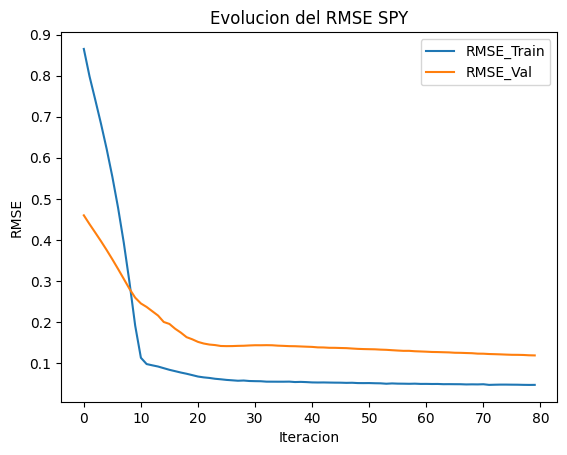

In [78]:
EPOCHS_SPY = 80 #iteraciones de entrenamiento
BATCH_SIZE_SPY = 256 #tamaño del lote (es decir, 256 datos de entrenamiento en cada iteración)

historia_SPY = modelo_SPY.fit(
    x = x_tr_s_SPY,
    y = y_tr_s_SPY,
    batch_size = BATCH_SIZE_SPY,
    epochs = EPOCHS_SPY,
    validation_data = (x_vl_s_SPY, y_vl_s_SPY),
    verbose=2 #vemos como evoluciona el entrenamiento
)

plt.plot(historia_SPY.history['loss'],label='RMSE_Train')
plt.plot(historia_SPY.history['val_loss'],label='RMSE_Val')
plt.xlabel('Iteracion')
plt.ylabel('RMSE')
plt.title('Evolucion del RMSE SPY')
plt.legend()

# 5.6. Desempeño del Modelo

In [79]:
rmse_tr = modelo2.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo2.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo2.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

In [80]:
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.029
  RMSE val:	 0.101
  RMSE test:	 0.048


VIX

In [92]:
rmse_tr_VIX = modelo_VIX.evaluate(x=x_tr_s_VIX, y=y_tr_s_VIX, verbose=0)
rmse_vl_VIX = modelo_VIX.evaluate(x=x_vl_s_VIX, y=y_vl_s_VIX, verbose=0)
rmse_ts_VIX = modelo_VIX.evaluate(x=x_ts_s_VIX, y=y_ts_s_VIX, verbose=0)

print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr_VIX:.3f}')
print(f'  RMSE val:\t {rmse_vl_VIX:.3f}')
print(f'  RMSE test:\t {rmse_ts_VIX:.3f}')

Comparativo desempeños:
  RMSE train:	 0.029
  RMSE val:	 0.104
  RMSE test:	 0.049


SPY

In [82]:
rmse_tr_SPY = modelo_SPY.evaluate(x=x_tr_s_SPY, y=y_tr_s_SPY, verbose=0)
rmse_vl_SPY = modelo_SPY.evaluate(x=x_vl_s_SPY, y=y_vl_s_SPY, verbose=0)
rmse_ts_SPY = modelo_SPY.evaluate(x=x_ts_s_SPY, y=y_ts_s_SPY, verbose=0)

print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr_SPY:.3f}')
print(f'  RMSE val:\t {rmse_vl_SPY:.3f}')
print(f'  RMSE test:\t {rmse_ts_SPY:.3f}')

Comparativo desempeños:
  RMSE train:	 0.030
  RMSE val:	 0.112
  RMSE test:	 0.054


Resumen de modelos

In [83]:
# Datos de RMSE para cada modelo
data = {
    'BTC': {'Train': rmse_tr, 'Val': rmse_vl, 'Test': rmse_ts},
    'VIX': {'Train': rmse_tr_VIX, 'Val': rmse_vl_VIX, 'Test': rmse_ts_VIX},
    'SPY': {'Train': rmse_tr_SPY, 'Val': rmse_vl_SPY, 'Test': rmse_ts_SPY},
}

# Crear un DataFrame de Pandas
df = pd.DataFrame(data)

# Transponer para tener modelos en filas y conjuntos en columnas
df = df.T

# Imprimir la tabla resumen
print("Tabla Resumen de RMSE:")
print(df)

Tabla Resumen de RMSE:
        Train       Val      Test
BTC  0.029384  0.101461  0.047894
VIX  0.029339  0.103520  0.049125
SPY  0.029851  0.111771  0.053762


# 5.7. Predicciones (forecasting) con el modelo entrenado

In [84]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [85]:
y_ts_pred = predecir(x_ts_s, modelo2, scaler)

In [86]:
N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)

Text(0.5, 1.0, 'Errores de predicción BTC')

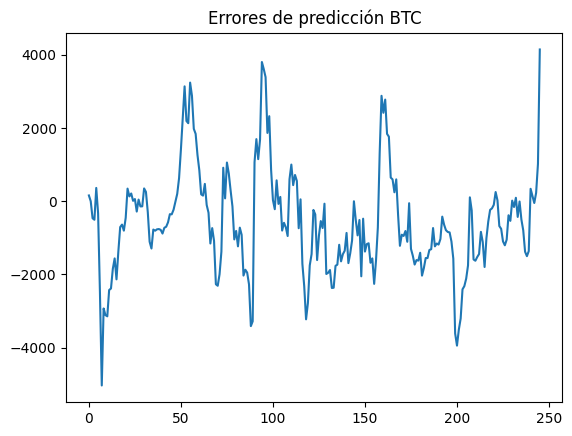

In [87]:
# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores)
plt.title('Errores de predicción BTC')

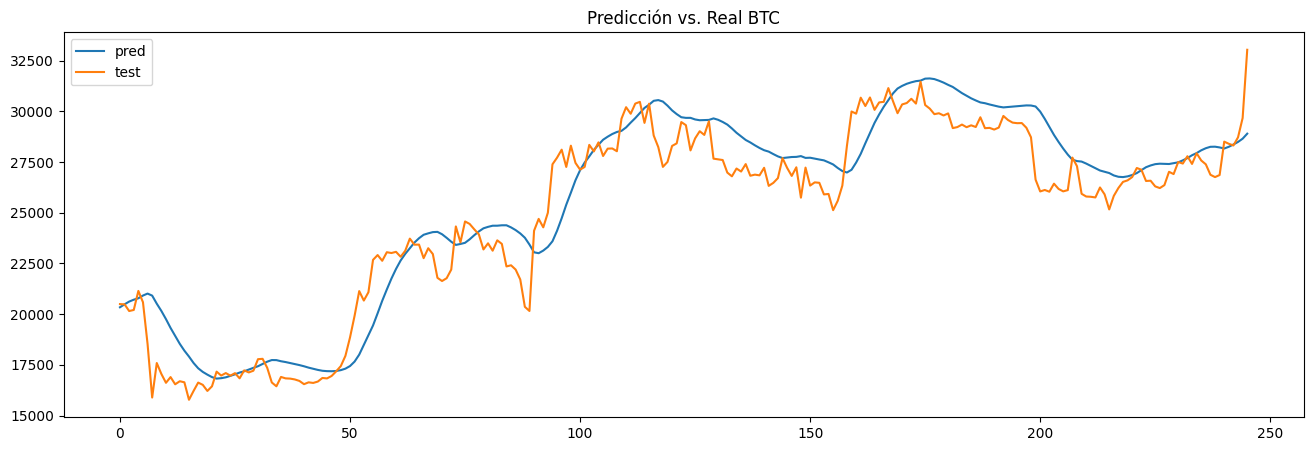

In [88]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(y_ts_pred,label="pred")
ax.plot(y_ts.flatten(),label="test")
plt.title('Predicción vs. Real BTC')
plt.legend()

VIX

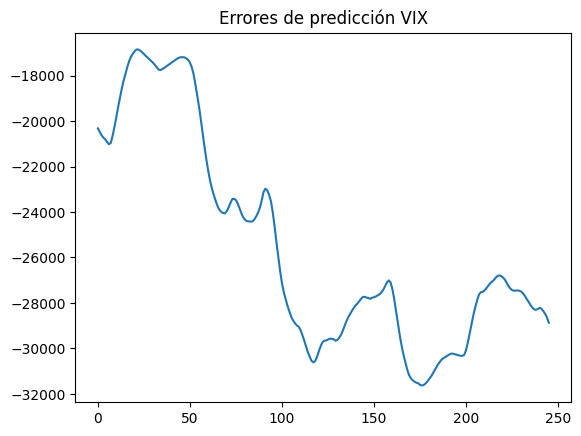

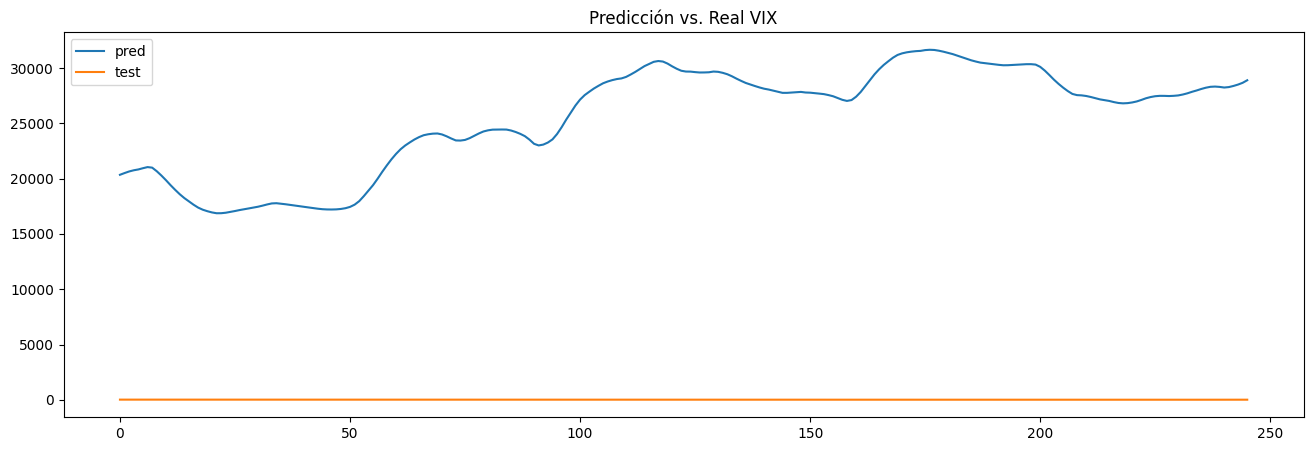

In [89]:
y_ts_pred_VIX = predecir(x_ts_s_VIX, modelo_VIX, scaler_VIX)

N_VIX = len(y_ts_pred_VIX)    # Número de predicciones (tamaño del set de prueba)
ndato_VIX = np.linspace(1,N_VIX,N_VIX)

# Cálculo de errores simples
errores_VIX = y_ts_VIX.flatten()-y_ts_pred_VIX
plt.plot(errores_VIX)
plt.title('Errores de predicción VIX')

fig, ax = plt.subplots(figsize=(16,5))
ax.plot(y_ts_pred_VIX,label="pred")
ax.plot(y_ts_VIX.flatten(),label="test")
plt.title('Predicción vs. Real VIX')
plt.legend()

SPY

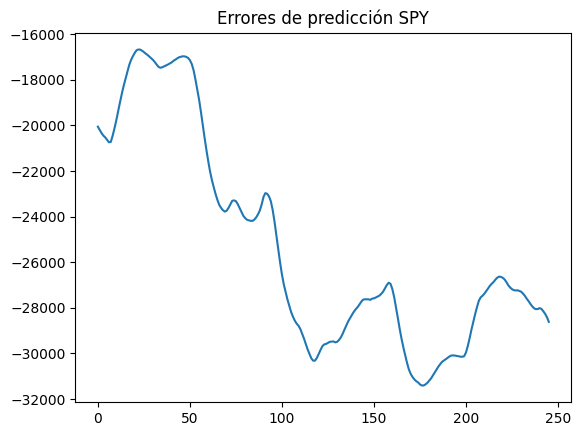

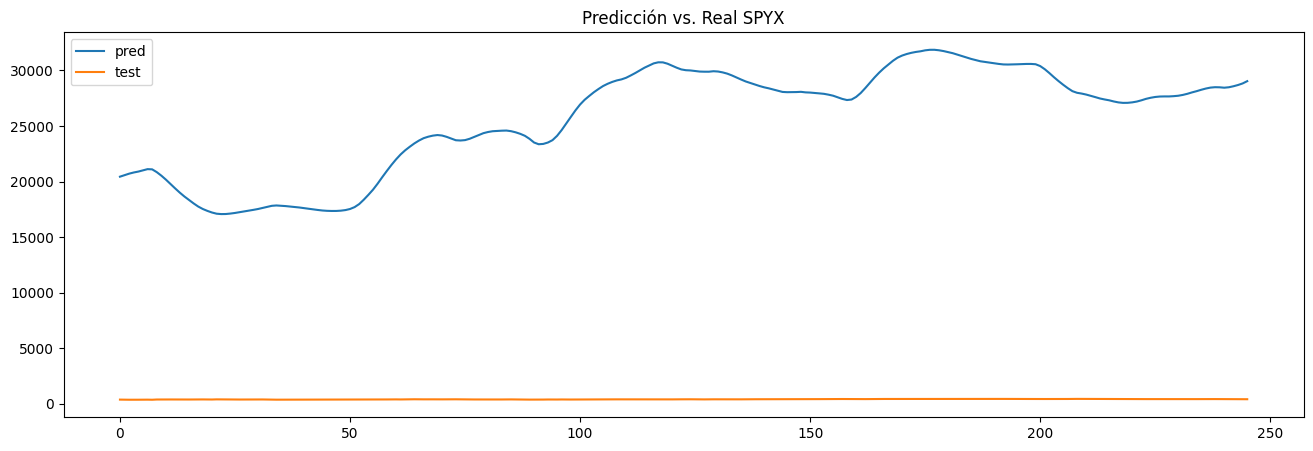

In [90]:
y_ts_pred_SPY = predecir(x_ts_s_SPY, modelo_SPY, scaler_SPY)

N_SPY = len(y_ts_pred_SPY)    # Número de predicciones (tamaño del set de prueba)
ndato_SPY = np.linspace(1,N_SPY,N_SPY)

# Cálculo de errores simples
errores_SPY = y_ts_SPY.flatten()-y_ts_pred_SPY
plt.plot(errores_SPY)
plt.title('Errores de predicción SPY')

fig, ax = plt.subplots(figsize=(16,5))
ax.plot(y_ts_pred_SPY,label="pred")
ax.plot(y_ts_SPY.flatten(),label="test")
plt.title('Predicción vs. Real SPYX')
plt.legend()